In [1]:
%matplotlib inline

# Multiclass Classification with Keras

**Course**: CMSC 389A Practical Deep Learning  
**Author**: Sujith Vishwajith

**Task**: Up until now we have mainly been talking about binary classification. That is identifying whether an example either belongs to the class (1) or doesn't (0). We will now discuss multiclass classification which allows you to decide which class an example belongs to out of more than 2 options. In our example today, we will be classifying which type of Iris a flower is based on its features. There are three classes of Iris flowers: Iris Setosa, Iris Versicolor, and Iris Virginica. Our features for the plant are:
1. Sepal Length (cm)
2. Sepal Width (cm)
3. Petal Length (cm)
4. Petal Width (cm)

This notebook is meant to supplement this week's lecture and give a reference for Practical 2.

**Packages**  
Lets import the following required packages.

In [53]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Fixed seed for reproducibility
kSEED = 5
np.random.seed(kSEED)

## Load Data

We'll be using the Iris dataset provided by UCI [here](http://archive.ics.uci.edu/ml/machine-learning-databases/iris/) to train our model.

**Reading the Data** 
Let's first load and read the dataset into our program.

In [29]:
file_name = 'Iris.csv'
columns = [
    'Sepal Length (cm)',
    'Sepal Width (cm)',
    'Petal Length (cm)',
    'Petal Width (cm)',
    'Species'
]

df = pd.read_csv(file_name, names=columns, delimiter=',', header=0)
df[columns[:-1]] = df[columns[:-1]].astype(float)
df[columns[-1]] = df[columns[-1]].astype(str)

Lets take a peek at the data.

In [30]:
df.head()

,Sepal Length (cm),Sepal Width (cm),Petal Length (cm),Petal Width (cm),Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


As usual, let's normalize all the values between -1 and 1. Remember that this only applied to continous values not one hot class encodings (e.g. Male -> 0, Female -> 1).

In [5]:
# Normalize all the values between -1 and 1 as discussed in class
for feature in df.columns[:-1]:
    max_value = df[feature].max()
    min_value = df[feature].min()
    mean_value = df[feature].mean()
    df[feature] = (df[feature] - mean_value) / (max_value - min_value)

Lets now examine the data after normalizing it.

In [6]:
df.head()

,Sepal Length (cm),Sepal Width (cm),Petal Length (cm),Petal Width (cm),Species
0,-0.206481,0.185833,-0.399774,-0.416111,Iris-setosa
1,-0.262037,-0.022500,-0.399774,-0.416111,Iris-setosa
2,-0.317593,0.060833,-0.416723,-0.416111,Iris-setosa
3,-0.345370,0.019167,-0.382825,-0.416111,Iris-setosa
4,-0.234259,0.227500,-0.399774,-0.416111,Iris-setosa


## Load the examples into a data variable

Similar to what we did before, we will create a list `data` that contains all our examples in the dataset.

In [7]:
class Example:
    """
    Class to represent a data example.
    """

    def __init__(self, features, label):
        """
        Create a new example.

        :param label: The label (0 / 1) of the example
        :param vocab: The real valued features of patient (list)
        """
        self.features = features
        self.label = label

In [31]:
data = []
for row in df.itertuples():
    label = row[-1]
    features = row[1:-1]
    example = Example(features, label)
    data.append(example)

In [32]:
data = shuffle(data, random_state=kSEED)

X = [example.features for example in data]
y = [example.label for example in data]

## Encoding the Labels

Before, our output variable only contained a binary label (either a 1 or a 0) that we wanted to predict. In this case, we have 3 potential output classes represented as strings. A common practice to use in this scenario is to create a one hot encoding for each class. A one-hot encoding is a matrix where each class is assigned an index and if the value at the index is True (>1), the data point belongs to that class. For example lets say our encoding looks like the following:

Iris Setosa (index 0), Iris Versicolor (index 1), Iris Virginica (index 2)  
If flower is Iris Setosa: `[1,0,0]`  
If flower is Iris Versicolor: `[0,1,0]`  
If flower is Iris Virginica: `[0,0,1]`  

This is nice because our network can simply output a 1x3 vector (3 output nodes) where it contains the probability of being that class at each index. We can then just take the class with the highest probability and that is our class.

Encoding the classes is really easy to do if you take advantage of sklearn's `Label Encoder`.

In [33]:
encoder =  LabelEncoder()
encoded_y = encoder.fit_transform(y)
dummy_y = pd.get_dummies(encoded_y).values

Lets take a look at the encoded values for the fist 5 rows.

In [34]:
for i in range(5):
    print('{:} -> {:}'.format(y[i], dummy_y[i]))

Iris-versicolor -> [0 1 0]
Iris-virginica -> [0 0 1]
Iris-virginica -> [0 0 1]
Iris-setosa -> [1 0 0]
Iris-virginica -> [0 0 1]


## Train-test Split

We will take a random 80% for training examples and a random 20% for testing. We can do this quickly using sklearn's train test split function.
 
Note how we use `dummy_y` instead of `y` as it contains our encoded vector.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,dummy_y,test_size=0.2, random_state=kSEED)

print('Total Examples: {:}\nTrain Examples: {:}\nTest Examples: {:4d}'.format(len(data), len(X_train), len(X_test)))

Total Examples: 150
Train Examples: 120
Test Examples:   30


## Implementing the Model

Notice how our model architecture looks extremely similar to the one we used for the binary classification task on the Diabetes dataset. The only big difference here is in the last line of the model where our final dense layer contains 3 neurons rather than 1. This is because each neuron will correspond to each of the Iris classes and contain a probability for each class.

For example if the model output was `[0.8, 0.1, 0.1]`, then the predicted class is Iris Setosa.

In [37]:
model = Sequential()
model.add(Dense(16,input_shape=(4,),activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))

### Compiling the Model

Before we used the `binary_crossentropy` loss in the Diabetes dataset. We will now use the `category_crossentropy` loss to handle more than two classes. Check out the link [here](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) for more information on the differences between the two but just remember that binary is for two classes and categorical is for more than two.

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Summary

To get a quick overview of our model, we can use the `.summary()` property of Keras.

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 27        
Total params: 243
Trainable params: 243
Non-trainable params: 0
_________________________________________________________________


### Training the Model

We will train then neural network on the data we setup before. We will train for 100 epochs with a batch size of 10.

In [40]:
model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
120/120 [==============================] - 0s - loss: 2.6940 - acc: 0.3250     
Epoch 2/100
120/120 [==============================] - 0s - loss: 2.1365 - acc: 0.3250     
Epoch 3/100
120/120 [==============================] - 0s - loss: 1.6771 - acc: 0.3250     
Epoch 4/100
120/120 [==============================] - 0s - loss: 1.3775 - acc: 0.3250     
Epoch 5/100
120/120 [==============================] - 0s - loss: 1.2051 - acc: 0.3417     
Epoch 6/100
120/120 [==============================] - 0s - loss: 1.1052 - acc: 0.4333     
Epoch 7/100
120/120 [==============================] - 0s - loss: 1.0414 - acc: 0.4083     
Epoch 8/100
120/120 [==============================] - 0s - loss: 1.0015 - acc: 0.3667     
Epoch 9/100
120/120 [==============================] - 0s - loss: 0.9695 - acc: 0.3500     
Epoch 10/100
120/120 [==============================] - 0s - loss: 0.9445 - acc: 0.4250     
Epoch 11/100
120/120 [==============================] - 0s - loss: 0.9191 - acc

120/120 [==============================] - 0s - loss: 0.2481 - acc: 0.9750     
Epoch 90/100
120/120 [==============================] - 0s - loss: 0.2435 - acc: 0.9750     
Epoch 91/100
120/120 [==============================] - 0s - loss: 0.2416 - acc: 0.9750     
Epoch 92/100
120/120 [==============================] - 0s - loss: 0.2413 - acc: 0.9667     
Epoch 93/100
120/120 [==============================] - 0s - loss: 0.2331 - acc: 0.9750     
Epoch 94/100
120/120 [==============================] - 0s - loss: 0.2311 - acc: 0.9750     
Epoch 95/100
120/120 [==============================] - 0s - loss: 0.2318 - acc: 0.9583     
Epoch 96/100
120/120 [==============================] - 0s - loss: 0.2306 - acc: 0.9667     
Epoch 97/100
120/120 [==============================] - 0s - loss: 0.2217 - acc: 0.9750     
Epoch 98/100
120/120 [==============================] - 0s - loss: 0.2255 - acc: 0.9750     
Epoch 99/100
120/120 [==============================] - 0s - loss: 0.2156 - acc: 0.

### Evaluating the Model

We can now run the model on our test data and check the accuracy of the model. Since our `y_test` will be a matrix with a 1 at an element and our predicted output will also be a matrix but with probabilities at each index, we can check if we got the right class by selecting the index with the highest value. In the case of `y_test`, it will always be the correct class and in the case of our prediction, it will be the class we are most confident it is as the probabilities in the output vector sum up to 1.

In [45]:
y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

accuracy = accuracy_score(y_test_class, y_pred_class)
print(accuracy)

0.966666666667


### Results

As you can see, we achieve an incredible accuracy of 96.7% on the prediction task. This was also trained super quickly and with a minimal amount of code. We can see the power of neural networks for classification.

## Analysis Report

Here are the scorse computed based on what we talked about in class.  

In [50]:
print(classification_report(y_test_class,y_pred_class))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         6
          1       1.00      0.91      0.95        11
          2       0.93      1.00      0.96        13

avg / total       0.97      0.97      0.97        30



A visualization of the confusion matrix for our model. The confusion matrix helps us learn what the model predicted in comparison to the ground truth class. This allows us to identify where the model goes wrong in general. You can learn more about confusion matrices [here](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


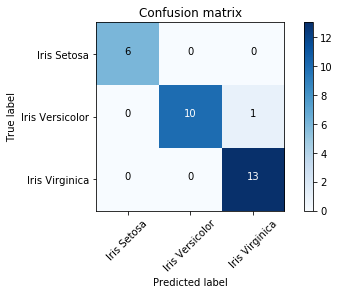

In [56]:
cnf_matrix = confusion_matrix(y_test_class,y_pred_class)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Iris Setosa', 'Iris Versicolor', 'Iris Virginica'], title='Confusion matrix')